In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [2]:
# Shared Variables

TiCl40 = 200 # mol/m^3
O20 = 1000 # mol/m^3

end_time = 20
steps = 1000

times = np.linspace(0, end_time, steps)

A1 = 8.26e4
A2 = 1.4e5 
Ea = 88000 # J/mol
R = 8.314 # J/mol*K
T0 = 800 # K

isothermal_initial_conditions = (TiCl40, O20)
isobaric_initial_conditions = (TiCl40, O20, T0)

# P will not be defined so that the reactant concentrations can be altered directly

In [3]:
# Thermodynamic Data:

A_TiCl4 = 143.0480
B_TiCl4 = 7.600362
C_TiCl4 = 1.530575
D_TiCl4 = -0.538376
E_TiCl4 = -0.020638

A_O2 = 30.03235
B_O2 = 8.772972
C_O2 = -3.988133
D_O2 = 0.788313
E_O2 = -0.741599

A_TiO2 = 67.29830
B_TiO2 = 18.70940
C_TiO2 = -11.57900
D_TiO2 = 2.449561
E_TiO2 = -1.485471

A_Cl2 = 42.67730
B_Cl2 = -5.009570
C_Cl2 = 1.904621
D_Cl2 = -0.165641
E_Cl2 = -2.098480

In [4]:
# Simple first order, constant T, constant P

def first_order_rates(variables, time):
    """
    Return the right hand side of the ODE
    """
    k = A1*np.exp(-Ea/(R*T0)) * 1e-3
    
    TiCl4, O2 = variables
    rate_TiCl4 = -k*TiCl4*O2
    rate_O2 = -k*TiCl4*O2
    return (rate_TiCl4, rate_O2)

In [5]:
# Actual rate equation, constant T, constant P

def isothermal_rates(variables, time):
    """
    Return the right hand side of the ODE
    """
    
    k1 = A1*np.exp(-Ea/(R*T0)) * 1e-3

    k2 = A2*np.exp(-Ea/(R*T0)) * 1e-3
    
    TiCl4, O2 = variables
    if O2 - (k1+k2*np.sqrt(O2))*TiCl4*end_time/steps <= 0 or np.isclose(0,O2) :
        return (0, 0)
    
    else:
        rate_TiCl4 = -(k1+k2*np.sqrt(O2))*TiCl4
        rate_O2 = -(k1+k2*np.sqrt(O2))*TiCl4
        
        return (rate_TiCl4, rate_O2)

In [6]:
# Actual rate equation, non-constant T, constant P

def isobaric_rates(variables, time):
    """
    Return the right hand side of the ODE
    """
    TiCl4, O2, T = variables
    
    k1 = A1*np.exp(-Ea/(R*T)) * 1e-3

    k2 = A2*np.exp(-Ea/(R*T)) * 1e-3
    
    delHr = (T-726.85)*(12/125) - 102
    
    if O2 - (k1+k2*np.sqrt(O2))*TiCl4*end_time/steps <= 0 or np.isclose(0,O2) :
        return (0, 0, 0)
    
    else:
        rate_TiCl4 = -(k1+k2*np.sqrt(O2))*TiCl4
        rate_O2 = -(k1+k2*np.sqrt(O2))*TiCl4
        
        if isobaric_initial_conditions[1] < isobaric_initial_conditions[0]:
            X = -rate_O2/isobaric_initial_conditions[1]
        else:
            X = -rate_TiCl4/isobaric_initial_conditions[0]
        
        
        Cp_TiCl4 = A_TiCl4 + B_TiCl4*(T/1000) + C_TiCl4*((T/1000)**2) + D_TiCl4*((T/1000)**3) + E_TiCl4/((T/1000)**2)
        
        Cp_O2 = A_O2 + B_O2*(T/1000) + C_O2*((T/1000)**2) + D_O2*((T/1000)**3) + E_O2/((T/1000)**2)
        
        Cp_TiO2 = A_TiO2 + B_TiO2*(T/1000) + C_TiO2*((T/1000)**2) + D_TiO2*((T/1000)**3) + E_TiO2/((T/1000)**2)
        
        Cp_Cl2 = A_Cl2 + B_Cl2*(T/1000) + C_Cl2*((T/1000)**2) + D_Cl2*((T/1000)**3) + E_Cl2/((T/1000)**2)
        
        
        rate_T = -delHr * np.min(isobaric_initial_conditions) * X / (Cp_TiCl4 + Cp_O2 - Cp_TiO2 - 2*Cp_Cl2)
        
        #print(X, rate_T)
        
        return (rate_TiCl4, rate_O2, rate_T)

In [7]:
first_order_result = odeint(first_order_rates, isothermal_initial_conditions, times)
TiCl4_first_order = first_order_result[:,0]             
O2_first_order = first_order_result[:,1]

isothermal_result = odeint(isothermal_rates, isothermal_initial_conditions, times)
TiCl4_isothermal = isothermal_result[:,0]             
O2_isothermal = isothermal_result[:,1]

isobaric_result = odeint(isobaric_rates, isobaric_initial_conditions, times)
TiCl4_isobaric = isobaric_result[:,0]             
O2_isobaric = isobaric_result[:,1]
Ts_isobaric = isobaric_result[:,2]

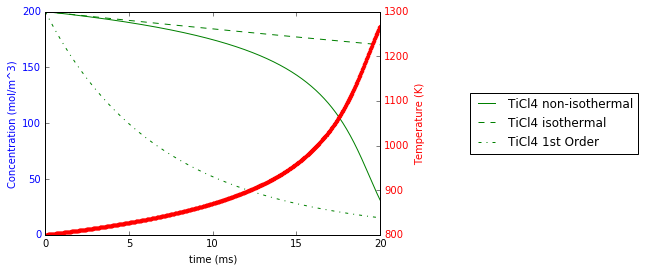

In [8]:
fig, ax1 = plt.subplots()
ax1.plot(times, TiCl4_isobaric, 'g-', label='TiCl4 non-isothermal')
#ax1.plot(times, O2_isobaric, 'b-', label='O2 non-isothermal')

ax1.plot(times, TiCl4_isothermal, 'g--', label='TiCl4 isothermal')
#ax1.plot(times, O2_isothermal, 'b--', label='O2 isothermal')

ax1.plot(times, TiCl4_first_order, 'g-.', label='TiCl4 1st Order')
#ax1.plot(times, O2_first_order, 'b-.', label='O2 1st Order')

ax1.set_xlabel('time (ms)')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Concentration (mol/m^3)', color='b', )
for tl in ax1.get_yticklabels():
    tl.set_color('b')

plt.legend(loc='center left', bbox_to_anchor=(1.25, .5))

ax2 = ax1.twinx()
ax2.plot(times, Ts_isobaric, 'r.', label='Temperature')
ax2.set_ylabel('Temperature (K)', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.show()

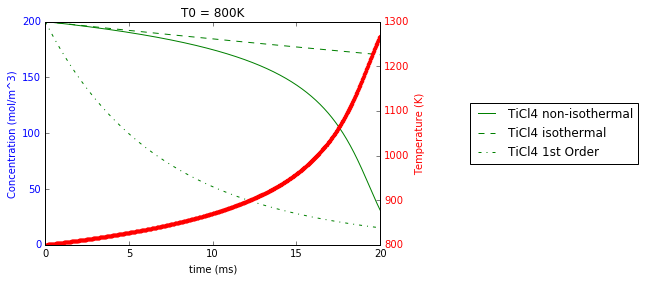

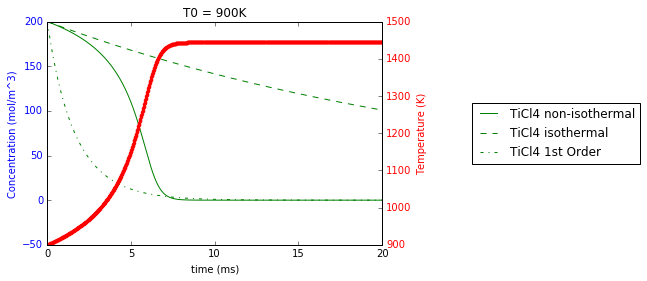

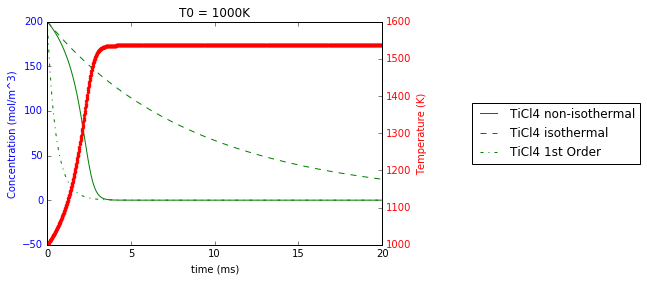

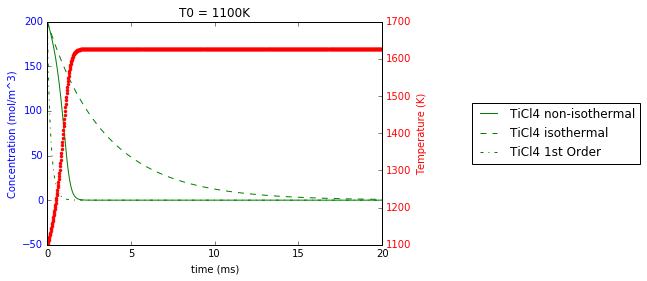

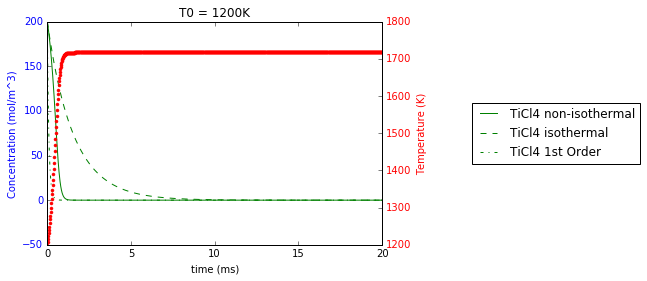

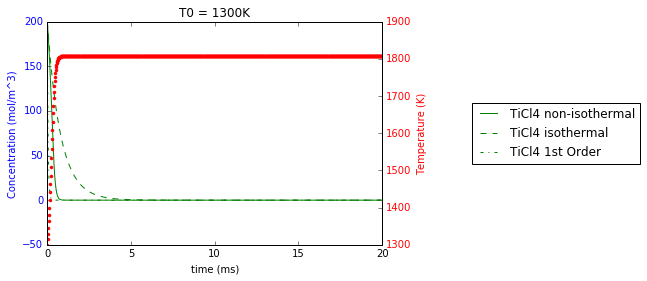

In [9]:
for T0 in range(800,1400,100):
    isobaric_initial_conditions = (TiCl40, O20, T0)
    
    first_order_result = odeint(first_order_rates, isothermal_initial_conditions, times)
    TiCl4_first_order = first_order_result[:,0]             
    O2_first_order = first_order_result[:,1]

    isothermal_result = odeint(isothermal_rates, isothermal_initial_conditions, times)
    TiCl4_isothermal = isothermal_result[:,0]             
    O2_isothermal = isothermal_result[:,1]

    isobaric_result = odeint(isobaric_rates, isobaric_initial_conditions, times)
    TiCl4_isobaric = isobaric_result[:,0]             
    O2_isobaric = isobaric_result[:,1]
    Ts_isobaric = isobaric_result[:,2]
    
    fig, ax1 = plt.subplots()
    plt.title('T0 = ' + str(T0) + 'K')
    ax1.plot(times, TiCl4_isobaric, 'g-', label='TiCl4 non-isothermal')
    #ax1.plot(times, O2_isobaric, 'b-', label='O2 non-isothermal')

    ax1.plot(times, TiCl4_isothermal, 'g--', label='TiCl4 isothermal')
    #ax1.plot(times, O2_isothermal, 'b--', label='O2 isothermal')

    ax1.plot(times, TiCl4_first_order, 'g-.', label='TiCl4 1st Order')
    #ax1.plot(times, O2_first_order, 'b-.', label='O2 1st Order')

    ax1.set_xlabel('time (ms)')

    # Make the y-axis label and tick labels match the line color.
    ax1.set_ylabel('Concentration (mol/m^3)', color='b', )
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    plt.legend(loc='center left', bbox_to_anchor=(1.25, .5))

    ax2 = ax1.twinx()
    ax2.plot(times, Ts_isobaric, 'r.', label='Temperature')
    # plt.ylim((1780,1790))
    ax2.set_ylabel('Temperature (K)', color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()

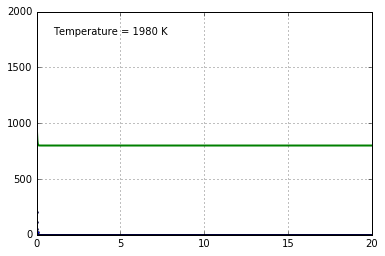

In [14]:
from matplotlib import animation
import matplotlib
matplotlib.rc('animation', html='html5')

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0,20), ylim=(0,2000))
ax.grid()

line1, = ax.plot([], [], 'o', ms=2)
line2, = ax.plot([], [], '-', lw=2)
line3, = ax.plot([], [], '-', lw=2)
temperature_template = 'Temperature = %.0f K'
temperature_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    temperature_text.set_text('')
    return line1, line2, line3, temperature_text

def animate(i):
    T = 800 + i*20
    isobaric_initial_conditions = (TiCl40, O20, T)
    
    isobaric_result = odeint(isobaric_rates, isobaric_initial_conditions, times)
    y1 = isobaric_result[:,0]             
    y2 = isobaric_result[:,1]
    y3 = isobaric_result[:,2]

    line1.set_data(times, y1)
    line2.set_data(times, y2)
    line3.set_data(times, y3)

    temperature_text.set_text(temperature_template%T)
    return line1, line2, line3, temperature_text

anim = animation.FuncAnimation(fig, animate, frames=60, blit=True, init_func=init)
anim

In [ ]:
anim